<a href="https://colab.research.google.com/github/GishB/Deep-Learning-project/blob/main/Project_binary_classification_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import all important libraries

In [1]:
#Import all libraries which is required for project tasks
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data
from torch.utils.data import Dataset
from torch.types import Device
import matplotlib.pyplot as plt 

import PIL
from PIL import Image
import torchvision
from torchvision import datasets, transforms, utils
from torchvision.datasets import ImageFolder


from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# Augumentation NORMAL chest X-rays. Increase number of NORMAL chest X-rays images from 1500 to 4622 pictures. Run just once and save in directory!

In [2]:
# path_to_folder = '/Users/peterbkh/miniconda3/deep-learning-liege/NORMAL'
# new_folder = 'test'



# for i in os.listdir(path_to_folder):
#   img_path = path_to_folder + '/' + i
#   print(i)
#   im = Image.open(img_path)
#   im = im.convert("RGB")

#   vertical_img = im.transpose(method=Image.FLIP_TOP_BOTTOM)
#   vertical_img.save(new_folder + "/vertical_" + i)

#   hor_img = im.transpose(method=Image.FLIP_LEFT_RIGHT)
#   hor_img.save(new_folder + "/horisontal_" + i)

# Import X-ray chest images from google drive directory. Here we have 4622 NORMAL and 4273 PNEUMONIA images

In [3]:
root_dir = '/content/drive/MyDrive/DATASET_FINAL/images' #root which contents all images in RGB
csv_dir = '/content/drive/MyDrive/DATASET_FINAL/x_ray_new.csv' #root to csv file which content in 0 column images name and in 1 column class

# Dataloader

In [4]:
class XRayChestDataset(Dataset):
  def __init__(self, csv_file, root_dir, transform=None):
    self.annotations = pd.read_csv(csv_file)
    self.root_dir = root_dir
    self.transform = transform
  
  def __len__(self):
    return len(self.annotations)

  def __getitem__(self, index):
    img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
 #   image = io.imread(img_path)
    image = Image.open(img_path).convert('RGB')
    y_label = torch.tensor(int(self.annotations.iloc[index, 1]))

    if self.transform:
      image = self.transform(image)

    return (image, y_label)

In [5]:
#transform rule for data
preprocess = transforms.Compose([
  #do size 64 to 64 to make computations faster for computer
  transforms.Resize(size=(64, 64)),
  #do transform.ToTensor for dataset in pytorch
  transforms.ToTensor(),
  transforms.RandomRotation(degrees = 5),
  transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
  ])

#Dataset which we are gonna working with
dataset = XRayChestDataset(csv_file = csv_dir, root_dir = root_dir, transform = preprocess)

#split data to 70/20/10 sets
number_of_images = len(dataset)

number_of_images_train = int(number_of_images*0.7)
number_of_images_test = int(number_of_images*0.2)
number_of_images_valid = number_of_images - number_of_images_train - number_of_images_test

train_set, test_set, valid_set = torch.utils.data.random_split(dataset, [number_of_images_train,
                                                                         number_of_images_test,
                                                                         number_of_images_valid])

In [6]:
#hint: DO NOT USE JUPYNER NOTEBOOK! IT DOSENT SUPPORT multiprocess. There is a lag when num_workers > 0!
train_loader = data.DataLoader(dataset=train_set, batch_size=32, shuffle=True, num_workers=2)
test_loader = data.DataLoader(dataset=test_set, batch_size=32, shuffle=False, num_workers=2)
valid_loader = data.DataLoader(dataset=valid_set, batch_size=1, shuffle=False, num_workers=2) 


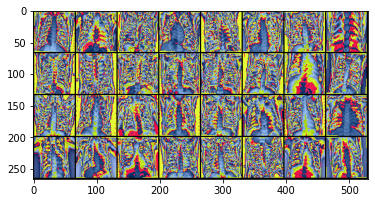

NORMAL PNEUMONIA NORMAL PNEUMONIA PNEUMONIA PNEUMONIA NORMAL PNEUMONIA NORMAL NORMAL NORMAL NORMAL NORMAL NORMAL PNEUMONIA NORMAL NORMAL PNEUMONIA PNEUMONIA PNEUMONIA NORMAL PNEUMONIA PNEUMONIA PNEUMONIA PNEUMONIA PNEUMONIA PNEUMONIA NORMAL NORMAL NORMAL PNEUMONIA PNEUMONIA


In [7]:
classes = ('NORMAL', 'PNEUMONIA')

def show_images(img):
    plt.imshow(transforms.functional.to_pil_image(img))
    plt.show()


images, labels = next(iter(train_loader))
show_images(utils.make_grid(images))  # should look weird due to normalization
print(*[classes[l] for l in labels])

#Should working about 1 minute before it shows images and labels

# Import models

In [8]:
#All models are based on PyTorch documentation and https://github.com/aladdinpersson/Machine-Learning-Collection.git
class MLP(nn.Module): 
    def __init__(self): 
        super().__init__()
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(12288, 4096) 
        self.fc2 = nn.Linear(4096, 2048)
        self.fc3 = nn.Linear(2048, 1024)
        self.fc4 = nn.Linear(1024,2)
        
    def forward(self, x): 
        x = self.fc1(self.flatten(x))
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)
        return x

In [9]:
class CNN(nn.Module): 
    def __init__(self): 
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3)
        self.pool = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.conv2 = nn.Conv2d(6,16,3) 
        self.fc1 = nn.Linear(3136, 1024) 
        self.fc2 = nn.Linear(1024, 248)
        self.drop = nn.Dropout(0.5)
        self.fc3 = nn.Linear(248, 32)
        self.fc4 = nn.Linear(32,2)
        
    def forward(self, x): 
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.reshape(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = F.relu(self.fc2(x))
        x = self.drop(x)
        x = F.relu(self.fc3(x))
        x = self.drop(x)
        x = self.fc4(x)
        return x

In [10]:
class VGG16(nn.Module): 
    def __init__(self): 
        super().__init__()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(3,3), padding=(1,1))
        self.conv2_0 = nn.Conv2d(in_channels=64, out_channels =64, kernel_size=(3,3), padding=(1,1))
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size= (2,2), stride = (2,2))
        self.conv2_1 = nn.Conv2d(64,128, kernel_size=(3,3), padding=(1,1))
        self.conv2_1_0 = nn.Conv2d(128, 128, kernel_size=(3,3), padding=(1,1))
        self.conv2_2 = nn.Conv2d(128,256, kernel_size=(3,3), padding=(1,1))
        self.conv2_2_0 = nn.Conv2d(256,256, kernel_size=(3,3), padding=(1,1))
        self.conv2_3 = nn.Conv2d(256,512, kernel_size=(3,3), padding=(1,1))
        self.conv2_3_0 = nn.Conv2d(512,512, kernel_size= (3,3), padding=(1,1))
        self.fcs = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 2)
        )
        
    def forward(self, x): 
        x = self.relu(self.conv2(x))
        x = self.maxpool(self.relu(self.conv2_0(x)))
        x = self.relu(self.conv2_1(x))
        x = self.maxpool(self.relu(self.conv2_1_0(x)))
        x = self.relu(self.conv2_2(x))
        x = self.relu(self.conv2_2_0(x))
        x = self.maxpool(self.relu(self.conv2_2_0(x)))
        x = self.relu(self.conv2_3(x))
        x = self.relu(self.conv2_3_0(x))
        x = self.maxpool(self.relu(self.conv2_3_0(x)))
        x = self.relu(self.conv2_3_0(x))
        x = self.relu(self.conv2_3_0(x))
        x = self.maxpool(self.relu(self.conv2_3_0(x)))
        x = x.reshape(x.shape[0], -1)
        x = self.fcs(x)
        return x

In [11]:
class block(nn.Module):
    def __init__(
        self, in_channels, intermediate_channels, identity_downsample=None, stride=1
    ):
        super(block, self).__init__()
        self.expansion = 4
        self.conv1 = nn.Conv2d(
            in_channels, intermediate_channels, kernel_size=1, stride=1, padding=0, bias=False
        )
        self.bn1 = nn.BatchNorm2d(intermediate_channels)
        self.conv2 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False
        )
        self.bn2 = nn.BatchNorm2d(intermediate_channels)
        self.conv3 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels * self.expansion,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=False
        )
        self.bn3 = nn.BatchNorm2d(intermediate_channels * self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
        self.stride = stride

    def forward(self, x):
        identity = x.clone()

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x


class ResNet(nn.Module):
    def __init__(self, block, layers, image_channels, num_classes):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Essentially the entire ResNet architecture are in these 4 lines below
        self.layer1 = self._make_layer(
            block, layers[0], intermediate_channels=64, stride=1
        )
        self.layer2 = self._make_layer(
            block, layers[1], intermediate_channels=128, stride=2
        )
        self.layer3 = self._make_layer(
            block, layers[2], intermediate_channels=256, stride=2
        )
        self.layer4 = self._make_layer(
            block, layers[3], intermediate_channels=512, stride=2
        )

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x

    def _make_layer(self, block, num_residual_blocks, intermediate_channels, stride):
        identity_downsample = None
        layers = []

        # Either if we half the input space for ex, 56x56 -> 28x28 (stride=2), or channels changes
        # we need to adapt the Identity (skip connection) so it will be able to be added
        # to the layer that's ahead
        if stride != 1 or self.in_channels != intermediate_channels * 4:
            identity_downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels,
                    intermediate_channels * 4,
                    kernel_size=1,
                    stride=stride,
                    bias=False
                ),
                nn.BatchNorm2d(intermediate_channels * 4),
            )

        layers.append(
            block(self.in_channels, intermediate_channels, identity_downsample, stride)
        )

        # The expansion size is always 4 for ResNet 50,101,152
        self.in_channels = intermediate_channels * 4

        # For example for first resnet layer: 256 will be mapped to 64 as intermediate layer,
        # then finally back to 256. Hence no identity downsample is needed, since stride = 1,
        # and also same amount of channels.
        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, intermediate_channels))

        return nn.Sequential(*layers)


def ResNet50(img_channel=3, num_classes=2):
    return ResNet(block, [3, 4, 6, 3], img_channel, num_classes)

In [12]:
class GoogLeNet(nn.Module): 
    def __init__(self, in_channels = 3 , num_classes=2): 
        super(GoogLeNet, self).__init__()

        self.conv1 = conv_block(in_channels=in_channels, out_channels=64, kernel_size=(7,7), stride=(2,2), padding=(3,3))
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv2 = conv_block(64, 192, kernel_size=3, stride=1, padding=1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.inception3a = Inception_block(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = Inception_block(256, 128, 128, 192, 32, 96, 64)
        self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.inception4a = Inception_block(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = Inception_block(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = Inception_block(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = Inception_block(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = Inception_block(528, 256, 160, 320, 32, 128, 128)
        self.maxpool4 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.inception5a = Inception_block(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = Inception_block(832, 384, 192, 384, 48, 128, 128)

        self.avgpool = nn.AvgPool2d(kernel_size = 2, stride=1)
        self.dropout = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(1024, 2)

    def forward(self, x): 
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        
        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool3(x)

        x = self.inception4a(x)
        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)
        x = self.inception4e(x)
        x = self.maxpool4(x)

        x = self.inception5a(x)
        x = self.inception5b(x)
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.dropout(x)
        x = self.fc1(x)
        return x


class Inception_block(nn.Module):
    def __init__(
        self, in_channels, out_1x1, red_3x3, out_3x3, red_5x5, out_5x5, out_1x1pool
    ):
        super(Inception_block, self).__init__()
        self.branch1 = conv_block(in_channels, out_1x1, kernel_size=1)

        self.branch2 = nn.Sequential(
            conv_block(in_channels, red_3x3, kernel_size=1),
            conv_block(red_3x3, out_3x3, kernel_size=3, padding=1),
        )

        self.branch3 = nn.Sequential(
            conv_block(in_channels, red_5x5, kernel_size=1),
            conv_block(red_5x5, out_5x5, kernel_size=5, padding=2),
        )

        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            conv_block(in_channels, out_1x1pool, kernel_size=1),
        )

    def forward(self, x):
        return torch.cat(
            [self.branch1(x), self.branch2(x), self.branch3(x), self.branch4(x)], 1
        )


class conv_block(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(conv_block, self).__init__()
        self.relu = nn.ReLU()
        self.conv = nn.Conv2d(in_channels, out_channels, **kwargs)
        self.batchnorm = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        return self.relu(self.batchnorm(self.conv(x)))

In [13]:
#Call all models directly here >>
model_MLP = MLP()
model_CNN = CNN()
model_VGG16 = VGG16()
model_ResNet = ResNet50()
model_GoogleNet = GoogLeNet()

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_MLP.to(device)
model_CNN.to(device)
model_VGG16.to(device)
model_ResNet.to(device)
model_GoogleNet.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_MLP.parameters(), lr = 0.01)

# Train, test and validate functions for models

In [15]:
def train(num_epochs, model_number): #anynetwork 

    train_avg_loss = []
    test_avg_loss = []
    test_accuracy = []

    for i in range(num_epochs):
        train_losses = []
        test_losses = []
        
        for x, y in train_loader:
            x = x.to(device) # your code !
            y = y.to(device) # your code !
            
            if model_number == 0:
              pred = model_MLP(x)
            elif model_number == 1:
              pred = model_CNN(x)
            elif model_number == 2:
              pred = model_VGG16(x)
            elif model_number == 3:
              pred = model_ResNet(x)
            elif model_number == 4:
              pred = model_GoogleNet(x)
            else:
              pred = model_MLP(x)

            loss = criterion(pred, y)
            train_losses.append(loss.detach())
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        with torch.no_grad():   
            correct = 0

            for x, y in test_loader:
                x = x.to(device) # your code !!
                y = y.to(device) # your code !!
                
                if model_number == 0:
                  pred = model_MLP(x)
                elif model_number == 1:
                  pred = model_CNN(x)
                elif model_number == 2:
                  pred = model_VGG16(x)
                elif model_number == 3:
                  pred = model_ResNet(x)
                elif model_number == 4:
                  pred = model_GoogleNet(x)
                else:
                  pred = model_MLP(x)

                loss = criterion(pred, y)
                test_losses.append(loss)
                
                y_pred = pred.argmax(dim=-1)
                correct = correct + (y_pred == y).sum()

            accuracy = correct / len(test_set)

        
        train_losses = torch.as_tensor(train_losses) #UPDATE5.1 (avoid copy), it is important  for .append
        test_losses = torch.as_tensor(test_losses) #UPDATE5.1 (avoid copy), it is important for .append
        
        mean_test_loss = torch.mean(test_losses) #UPDATE5.2 TO CONTROL PRINT
        mean_train_loss = torch.mean(train_losses) #UPDATE5.2 TO CONTROL PRINT
        
        train_avg_loss.append(mean_train_loss) # your code UPDATE5
        test_avg_loss.append(mean_test_loss) # your code UPDATE5
        test_accuracy.append(accuracy) # your code UPDATE5
        
        print(f'This is {i} epoch. \n Test loss = {mean_test_loss}, Train loss = {mean_train_loss}, Accuracy = {accuracy}')
    test_accuracy = torch.tensor(test_accuracy)
    return train_avg_loss, test_avg_loss, test_accuracy  # UPDATE4

In [16]:
def sigmoid_output_transform(output):
  y_pred = torch.sigmoid(output)
  return y_pred

def roc_auc_compute_fn(y_preds: torch.Tensor, y_targets: torch.Tensor) -> float:
    y_true = y_targets.cpu().numpy()
    y_pred = y_preds.cpu().numpy()
    return roc_auc_score(y_true, y_pred)

def roc_auc_curve_compute_fn(y_preds: torch.Tensor, y_targets: torch.Tensor):
    y_true = y_targets.numpy()
    y_pred = y_preds.numpy()
    return roc_curve(y_true, y_pred)

In [17]:
def validate_model(valid_loader, model_number):

  true_positive = 0
  true_negative = 0
  false_negative = 0
  false_positive = 0


  #two list objects keep results of prediciton (probability) and real data class
  list_pred = []
  list_data_1 = []
  
  for x, y in valid_loader:
    x = x.to(device) # data to device - important
    y = y.to(device) # data to device - important
                    
    if model_number == 0:
        pred = model_MLP(x)
    elif model_number == 1:
        pred = model_CNN(x)
    elif model_number == 2:
        pred = model_VGG16(x)
    elif model_number == 3:
        pred = model_ResNet(x)
    elif model_number == 4:
        pred = model_GoogleNet(x)
    else:
        pred = model_MLP(x)
    
    y_pred = pred.argmax(dim=-1)
    y_pred_test = sigmoid_output_transform(y_pred)
    list_pred.append(y_pred_test)    
    list_data_1.append(y)

  #Logic if - else for TP, TF, FP, FN
    if y_pred == y:
      if y == 1:
        true_positive = true_positive + (y == 1).sum()
      elif y == 0:
        true_negative = true_negative + (y == 0).sum()
    elif y_pred != y:
      if y == 1:
        false_positive = false_positive + (y == 1).sum()
      elif y == 0:
        false_negative = false_negative + (y == 0).sum()

  # list objects to torch.tensor
  list_pred = torch.tensor(list_pred) #this is predicted classes (probability)
  list_data_1 = torch.tensor(list_data_1) #this is original classes

  #Compute ROC-AUC parameters with def from scipy
  auc = roc_auc_compute_fn(list_pred, list_data_1)
  curve_test = roc_auc_curve_compute_fn(list_pred, list_data_1)

  precision = true_positive / ( true_positive + false_positive )
  recall = true_positive / ( true_positive + false_negative )
  F1_score = precision*recall*2/(precision + recall)

  plt.plot(curve_test[0], curve_test[1], color='darkorange',label='ROC curve (area = %0.2f)' % auc)
  plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC/AUC curve')
  plt.legend(loc="lower right")
  plt.show()
  print(f'F1 = {F1_score}, Precision = {precision}, Recall = {recall}, True positive = {true_positive}, True negative = {true_negative}')
  print(f'False positive = {false_positive}, False negative = {false_negative}')
  return F1_score, precision, recall, true_positive, true_negative, false_positive, false_negative, auc, curve_test

# Running models

In [18]:
#Train block

list_models = ['MLP', 'CNN', 'VGG16', 'ResNet', 'GoogleNet'] #All models which is used in the project
num_epochs = 10 #Chose random number of epochs - 50 is fine to see how a model works with dataset

#Save model parameters to plot model results
dict_models_params = {}

for i in range(0,5):
  print('######################################### \n Start training')
  print(f'Working with {list_models[i]}')

  train_avg_loss, test_avg_loss, test_accuracy = train(num_epochs, i) #train model
  validate_results = validate_model(valid_loader, i) #check accuracy, F1, TP, FP and etc.

  #Save params
  dict_models_params[list_models[i]] = train_avg_loss, test_avg_loss, test_accuracy, validate_results
  
  #Save trained model
  if i == 0:
    model = model_MLP
    path = '/content/drive/MyDrive/DATASET_FINAL/' + list_models[i]
  elif i == 1:
    model = model_CNN
    path = '/content/drive/MyDrive/DATASET_FINAL/' + list_models[i]
  elif i == 2:
    model = model_VGG16
    path = '/content/drive/MyDrive/DATASET_FINAL/' + list_models[i]    
  elif i == 3:
    model = model_ResNet 
    path = '/content/drive/MyDrive/DATASET_FINAL/' + list_models[i]    
  elif i == 4:
    model = model_GoogleNet
    path = '/content/drive/MyDrive/DATASET_FINAL/' + list_models[i] 

  print("Model's state_dict:")
  for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())
  torch.save(model.state_dict(), path)
  print('Finish training \n #########################################')

######################################### 
 Start training
Working with MLP
This is 0 epoch. 
 Test loss = 1.9360555410385132, Train loss = 229.197998046875, Accuracy = 0.855064332485199
This is 1 epoch. 
 Test loss = 0.25107061862945557, Train loss = 0.23507995903491974, Accuracy = 0.9210968017578125
This is 2 epoch. 
 Test loss = 0.15560822188854218, Train loss = 0.19417043030261993, Accuracy = 0.952434241771698


KeyboardInterrupt: ignored

# Plot models results

In [ ]:
for i in range(0,5):
  params_temp = dict_models_params[list_models[i]]
  fig, ax = plt.subplots(2,1, figsize=(15,15))
  ax[0].set_title('Training Loss')
  ax[0].plot(params_temp[0], label='Train average loss' +' '+ list_models[i])
  ax[0].plot(params_temp[1], label='Test average loss' +' '+ list_models[i])
  ax[1].plot(params_temp[2], label='Test accuracy' +' '+ list_models[i])
  ax[1].set_ylim([0, 1])
  ax[0].legend()
  ax[0].set_xlabel('Number epochs')
  ax[0].set_ylabel('Loss (Cross Entropy)')
  ax[1].legend()
  ax[1].set_xlabel('Number epochs')
  ax[1].set_ylabel('Accuracy percent')